<a href="https://colab.research.google.com/github/dathere/notebooks/blob/master/Realtime_Rt_mcmc_NYC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimating COVID-19's $R_t$ in Real-Time for all US counties

Modified version of the work by [Kevin Systrom](https://github.com/k-sys/covid-19) to estimate $R_t$ for all US states based on the [NYT](https://github.com/nytimes/covid-19-data) county level data

In [0]:
!pip install pymc3==3.8

     |████████████████████████████████| 911kB 2.8MB/s 
     |████████████████████████████████| 1.5MB 47.3MB/s 
     |████████████████████████████████| 4.1MB 34.9MB/s 
     |████████████████████████████████| 327kB 48.5MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

## Load COUNTY Information

In [0]:
# Import NYT data
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
counties = pd.read_csv(url,parse_dates=['date']).sort_index()

counties

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0
...,...,...,...,...,...,...
147240,2020-05-15,Sublette,Wyoming,56035.0,3,0
147241,2020-05-15,Sweetwater,Wyoming,56037.0,22,0
147242,2020-05-15,Teton,Wyoming,56039.0,99,1
147243,2020-05-15,Uinta,Wyoming,56041.0,9,0


In [0]:
#counties[counties.county != 'Unknown']
counties=counties[counties.county != 'Unknown']
counties.insert(0, 'key', counties['state'] + '_' + counties['county'])
counties.set_index(['key', 'date'],inplace=True)

# Example
#print(counties[counties['state'] == "Maine"]['county'].unique())
print(counties.head())

                                    county       state     fips  cases  deaths
key                  date                                                     
Washington_Snohomish 2020-01-21  Snohomish  Washington  53061.0      1       0
                     2020-01-22  Snohomish  Washington  53061.0      1       0
                     2020-01-23  Snohomish  Washington  53061.0      1       0
Illinois_Cook        2020-01-24       Cook    Illinois  17031.0      1       0
Washington_Snohomish 2020-01-24  Snohomish  Washington  53061.0      1       0


In [0]:
# Import USA Facts data
url = "https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv"
confirmed_df=pd.read_csv(url)#,parse_dates=['date']).sort_index()

#reshape USAFacts feed to expected format
counties_df = confirmed_df

#first, create a pseudo state called "NYC"
counties_df.loc[(confirmed_df['countyFIPS'].isin([36005, 36061, 36081, 36085, 36047])), 'State'] = 'NYC'
counties_df.loc[confirmed_df['County Name'] == 'New York City Unallocated/Probable', 'State'] = 'NYC'

counties_df = counties_df.melt(id_vars=["countyFIPS", "County Name", "State", "stateFIPS"], var_name="date", value_name="cases")

counties_df=counties_df.drop(columns=['countyFIPS', 'stateFIPS'])
counties_df.rename(columns={'State':'state', 'County Name':'county'}, inplace=True)

# create county aggregations so we can compute statewide Rt
county_agg = counties_df.groupby(['state','date']).agg({'cases':['sum']})
county_agg.columns = ['cases']
county_agg = county_agg.reset_index()
county_agg.insert(0, 'county', county_agg['state'])

county_agg

# merge state_aggregations with counties 
counties_df = counties_df.append(county_agg, ignore_index=True)
counties_df['date'] = pd.to_datetime(counties_df['date'])

# after aggregating statewide cases, remove the Unallocated entries
counties_df.drop(counties_df[counties_df.county.str.contains('Unallocated') ].index, inplace=True)
#counties_df.set_index(['county','date'], inplace=True)

counties_df


,county,state,date,cases
1,Autauga County,AL,2020-01-22,0
2,Baldwin County,AL,2020-01-22,0
3,Barbour County,AL,2020-01-22,0
4,Bibb County,AL,2020-01-22,0
5,Blount County,AL,2020-01-22,0
...,...,...,...,...
376647,WY,WY,2020-05-05,452
376648,WY,WY,2020-05-06,479
376649,WY,WY,2020-05-07,483
376650,WY,WY,2020-05-08,490


In [0]:
# Merge New York City data from NYT feed to USA Facts county feed to get best of both worlds

nycnyt = counties[counties['county'] == 'New York City']
del nycnyt['fips']
del nycnyt['deaths']
nycnyt['state'] = 'NYC'
nycnyt.reset_index(inplace=True)
del nycnyt['key']

nycnyt

counties_df = pd.concat([counties_df, nycnyt])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:

counties_df=counties_df[counties_df.county != 'Unknown']
counties_df.insert(0, 'key', counties_df['state'] + '_' + counties_df['county'])
counties_df.set_index(['key', 'date'],inplace=True)

counties_df

county state   cases
key               date                                    
AL_Autauga County 2020-01-22  Autauga County    AL       0
AL_Baldwin County 2020-01-22  Baldwin County    AL       0
AL_Barbour County 2020-01-22  Barbour County    AL       0
AL_Bibb County    2020-01-22     Bibb County    AL       0
AL_Blount County  2020-01-22   Blount County    AL       0
...                                      ...   ...     ...
NYC_New York City 2020-05-11   New York City   NYC  190546
                  2020-05-12   New York City   NYC  191320
                  2020-05-13   New York City   NYC  192394
                  2020-05-14   New York City   NYC  193663
                  2020-05-15   New York City   NYC  195472

[370812 rows x 3 columns]

In [0]:
counties = counties_df

## Load Patient Information
#### Download
~100mb download (be ... patient!)

In [0]:
def download_file(url, local_filename):
    """From https://stackoverflow.com/questions/16694907/"""
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    return local_filename


#URL = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv"
URL = "https://github.com/beoutbreakprepared/nCoV2019/raw/master/latest_data/latestdata.tar.gz"

LINELIST_PATH = 'data/linelist.csv.gz'

os.makedirs(os.path.dirname(LINELIST_PATH), exist_ok=True)

if not os.path.exists(LINELIST_PATH):
    print('Downloading file, this will take a while ~100mb')
    try:
        download_file(URL, LINELIST_PATH)
        clear_output(wait=True)
        print('Done downloading.')
    except:
        print('Something went wrong. Try again.')
else:
    print('Already downloaded CSV')

Done downloading.


In [0]:
#unzip file

import gzip
import shutil
with gzip.open(LINELIST_PATH, 'rb') as f_in:
    with open('data/linelist.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

#### Parse & Clean Patient Info

In [0]:
# Load the patient CSV
patients = pd.read_csv(
    'data/linelist.csv',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']
# colnames renamed ~05-07. rename back for code below to work
#patients.columns =  ['date_confirmation', 'date_onset_symptoms']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

#### Show Relationship between Onset of Symptoms and Confirmation

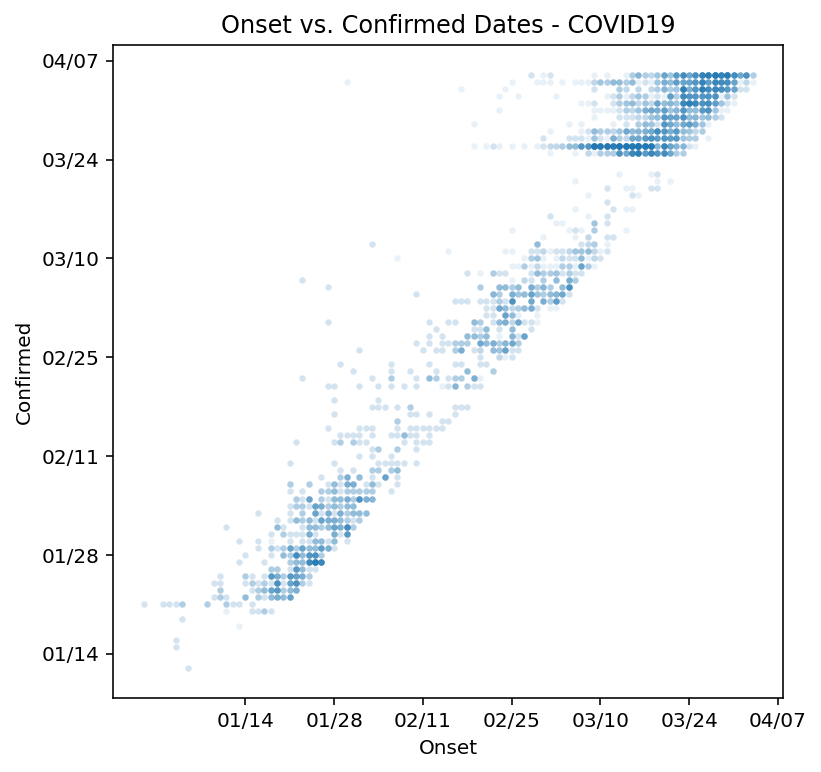

In [0]:
ax = patients.plot.scatter(
    title='Onset vs. Confirmed Dates - COVID19',
    x='Onset',
    y='Confirmed',
    alpha=.1,
    lw=0,
    s=10,
    figsize=(6,6))

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=2)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(formatter)
    axis.set_major_locator(locator)

#### Calculate the Probability Distribution of Delay

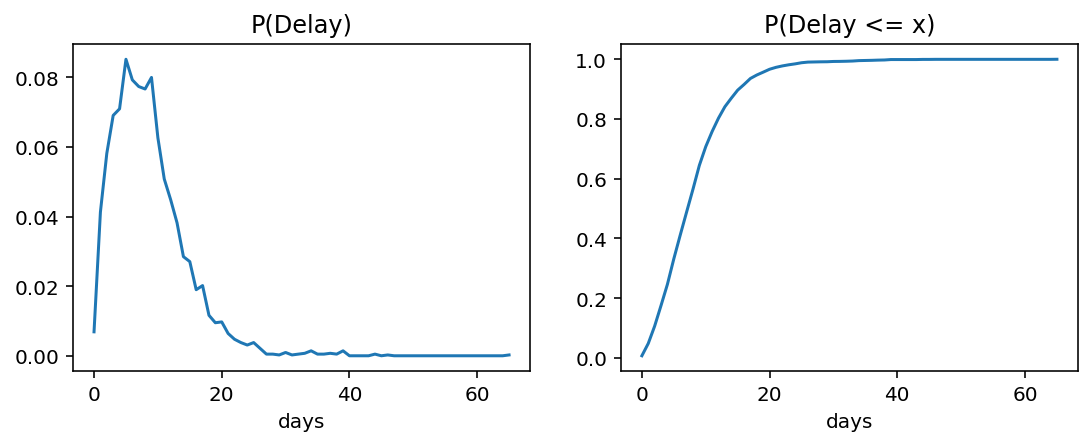

In [0]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

# A single County

In [0]:
#key = 'Nebraska_Douglas'
key = 'NYC_NYC'
key = 'NYC_New York City'
#key = 'New York_New York City'
#key = 'New Jersey_Hudson'
confirmed = counties.xs(key).cases.diff().dropna().clip(0) # new cases (not cumulative)
confirmed

date
2020-03-02       0.0
2020-03-03       1.0
2020-03-04       0.0
2020-03-05       2.0
2020-03-06       1.0
               ...  
2020-05-11     890.0
2020-05-12     774.0
2020-05-13    1074.0
2020-05-14    1269.0
2020-05-15    1809.0
Name: cases, Length: 75, dtype: float64

### Translate Confirmation Dates to Onset Dates

Our goal is to translate positive test counts to the dates where they likely occured. Since we have the distribution, we can distribute case counts back in time according to that distribution. To accomplish this, we reverse the case time series, and convolve it using the distribution of delay from onset to confirmation. Then we reverse the series again to obtain the onset curve. Note that this means the data will be 'right censored' which means there are onset cases that have yet to be reported so it looks as if the count has gone down.

In [0]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset



In [0]:
# onset for the selected county
onset = confirmed_to_onset(confirmed, p_delay)

### Adjust for Right-Censoring

Since we distributed observed cases into the past to recreate the onset curve, we now have a right-censored time series. We can correct for that by asking what % of people have a delay less than or equal to the time between the day in question and the current day.

For example, 5 days ago, there might have been 100 cases onset. Over the course of the next 5 days some portion of those cases will be reported. This portion is equal to the cumulative distribution function of our delay distribution. If we know that portion is say, 60%, then our current count of onset on that day represents 60% of the total. This implies that the total is 166% higher. We apply this correction to get an idea of what actual onset cases are likely, thus removing the right censoring.

In [0]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay

In [0]:
# adjusted for the selected county
adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)

Take a look at all three series: confirmed, onset and onset adjusted for right censoring.

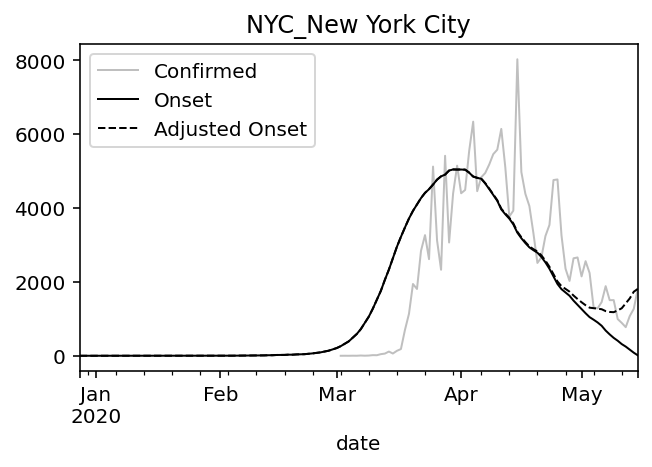

In [0]:
fig, ax = plt.subplots(figsize=(5,3))

confirmed.plot(
    ax=ax,
    label='Confirmed',
    title=key,
    c='k',
    alpha=.25,
    lw=1)

onset.plot(
    ax=ax,
    label='Onset',
    c='k',
    lw=1)

adjusted.plot(
    ax=ax,
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=1)

ax.legend();

Let's have the model run on days where we have enough data ~last 50 or so

### Sample the Posterior with PyMC3

We assume a poisson likelihood function and feed it what we believe is the onset curve based on reported data. We model this onset curve based on the same math in the previous notebook:

$$ I^\prime = Ie^{\gamma(R_t-1)} $$

We define $\theta = \gamma(R_t-1)$ and model $ I^\prime = Ie^{\theta} $ where $\theta$ observes a random walk. We let $\gamma$ vary independently based on known parameters for the serial interval. Therefore, we can recover $R_t$ easily by $R_t = \frac{\theta}{\gamma}+1$

The only tricky part is understanding that we're feeding in _onset_ cases to the likelihood. So $\mu$ of the poisson is the positive, non-zero, expected onset cases we think we'd see today.

We calculate this by figuring out how many cases we'd expect there to be yesterday total when adjusted for bias and plugging it into the first equation above. We then have to re-bias this number back down to get the expected amount of onset cases observed that day.

In [0]:
class MCMCModel(object):
    
    def __init__(self, region, onset, cumulative_p_delay, window=50):
        
        # Just for identification purposes
        self.region = region
        
        # For the model, we'll only look at the last N
        self.onset = onset.iloc[-window:]
        self.cumulative_p_delay = cumulative_p_delay[-window:]
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    def run(self, chains=1, tune=3000, draws=1000, target_accept=.95):

        with pm.Model() as model:

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sigma=.03)

            # Theta random walk
            theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
            theta_raw_steps = pm.Normal('theta_raw_steps', shape=len(self.onset)-2) * step_size
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta/gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
            
            return self
    
    def run_gp(self):
        with pm.Model() as model:
            gp_shape = len(self.onset) - 1

            length_scale = pm.Gamma("length_scale", alpha=3, beta=.4)

            eta = .05
            cov_func = eta**2 * pm.gp.cov.ExpQuad(1, length_scale)

            gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(c=0), 
                              cov_func=cov_func)

            # Place a GP prior over the function f.
            theta = gp.prior("theta", X=np.arange(gp_shape)[:, None])

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta / gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(chains=1, tune=1000, draws=1000, target_accept=.8)
        return self

### Run Pymc3 Model

In [0]:
def df_from_model(model):
    
    r_t = model.trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, credible_interval=.9)
    hpd_50 = pm.stats.hpd(r_t, credible_interval=.5)
    
    idx = pd.MultiIndex.from_product([
            [model.region],
            model.trace_index
        ], names=['region', 'date'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

In [0]:
def create_and_run_model_counties(name, county):
    confirmed = county.cases.diff().dropna().clip(0) # new cases (not cumulative)
    onset = confirmed_to_onset(confirmed, p_delay)
    adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
    return MCMCModel(name, onset, cumulative_p_delay).run()

In [0]:
print(counties[counties.state== 'NYC']['county'].unique())
#print(counties[counties.state== 'New York']['county'].unique())
#print(counties[counties.state== 'New Jersey']['county'].unique())

['Bronx County' 'Kings County' 'New York County' 'Queens County'
 'Richmond County' 'NYC' 'New York City']


In [0]:
models = {}
for state_county, grp in counties[counties['state']=='NYC'].groupby(level='key'): # only the selected state
#for state_county, grp in counties.groupby(level='key'): # all counties all states

    print(state_county)
    #print(grp.droplevel(0))
    if state_county in models:
        print(f'Skipping {state_county}, already in cache')
        continue
    models[state_county] = create_and_run_model_counties(state_county,grp.droplevel(0))

NYC_Bronx County


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:25<00:00, 154.74it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NYC_Kings County


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:25<00:00, 155.13it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NYC_NYC


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:46<00:00, 37.52it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NYC_New York City


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:44<00:00, 90.56it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


NYC_New York County


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:24<00:00, 163.59it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NYC_Queens County


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:24<00:00, 160.95it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NYC_Richmond County


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 2 divergences: 100%|██████████| 4000/4000 [00:23<00:00, 171.38it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8176965358474575, but should be close to 0.95. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


### Handle Divergences

In [0]:
# Check to see if there were divergences
n_diverging = lambda x: x.trace['diverging'].nonzero()[0].size
divergences = pd.Series([n_diverging(m) for m in models.values()], index=models.keys())
has_divergences = divergences.gt(0)

print('Diverging states:')
display(divergences[has_divergences])

# Rerun states with divergences
for state, n_divergences in divergences[has_divergences].items():
    models[state].run()

Diverging states:


NYC_Richmond County    2
dtype: int64

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:22<00:00, 177.11it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


## Compile Results

In [0]:
results = None

for state_county, model in models.items():

    df = df_from_model(model)

    if results is None:
        results = df
    else:
        results = pd.concat([results, df], axis=0)

In [0]:
results

mean    median  ...  lower_50  upper_50
region              date                            ...                    
NYC_Bronx County    2020-03-29  1.061379  1.051523  ...  0.996495  1.084367
                    2020-03-30  1.047469  1.041244  ...  0.992887  1.066721
                    2020-03-31  1.031196  1.027109  ...  0.984759  1.050503
                    2020-04-01  1.011881  1.008668  ...  0.985068  1.043536
                    2020-04-02  0.992309  0.994517  ...  0.962436  1.019450
...                                  ...       ...  ...       ...       ...
NYC_Richmond County 2020-05-12  0.816161  0.826021  ...  0.767628  0.979830
                    2020-05-13  0.815771  0.827908  ...  0.738647  0.954473
                    2020-05-14  0.814831  0.831079  ...  0.738956  0.961750
                    2020-05-15  0.815153  0.833670  ...  0.714081  0.963404
                    2020-05-16  0.816545  0.830692  ...  0.696318  0.954377

[343 rows x 6 columns]

### Render to CSV

In [0]:
!pip install ckanapi

  Created wheel for ckanapi: filename=ckanapi-4.3-cp36-none-any.whl size=38647 sha256=7386e673e4632f06bee1b28edcf6729a59e61b0111092de5a95282d8d06122a3
  Stored in directory: /root/.cache/pip/wheels/41/f2/fb/c8ce857007de64cc6b36b8f1048272396bc0817c35ee3a3e73
Successfully built ckanapi


In [0]:
# New York City
resultscsv=results.reset_index()
resultscsv.drop(resultscsv[resultscsv['region'] == 'NYC_NYC'].index, inplace=True)

resultscsv['region']= resultscsv['region'].str.replace("NYC_", "", case = False) 
resultscsv.rename(columns={"region": "county"}, inplace=True)

resultscsv

,county,date,mean,median,lower_90,upper_90,lower_50,upper_50
0,Bronx County,2020-03-29,1.061379,1.051523,0.935316,1.175313,0.996495,1.084367
1,Bronx County,2020-03-30,1.047469,1.041244,0.947281,1.148274,0.992887,1.066721
2,Bronx County,2020-03-31,1.031196,1.027109,0.934322,1.121856,0.984759,1.050503
3,Bronx County,2020-04-01,1.011881,1.008668,0.920906,1.096719,0.985068,1.043536
4,Bronx County,2020-04-02,0.992309,0.994517,0.911011,1.090486,0.962436,1.019450
...,...,...,...,...,...,...,...,...
338,Richmond County,2020-05-12,0.816161,0.826021,0.477263,1.120422,0.767628,0.979830
339,Richmond County,2020-05-13,0.815771,0.827908,0.463433,1.114733,0.738647,0.954473
340,Richmond County,2020-05-14,0.814831,0.831079,0.444925,1.114032,0.738956,0.961750
341,Richmond County,2020-05-15,0.815153,0.833670,0.478553,1.174685,0.714081,0.963404


In [0]:
maxdate = resultscsv['date'].max().strftime('%Y-%m-%d')
maxdate

'2020-05-16'

In [0]:
os.makedirs(os.path.dirname('results/'), exist_ok=True)
resultscsv.to_csv('results/rt_mcmc_nyc.csv', index=False)
#resultscsv.to_csv('results/rt_mcmc_nj.csv', index=False)

In [0]:
from ckanapi import RemoteCKAN
ua = 'ckanapi/4.3 (+https://data.beta.nyc)'

ckan = RemoteCKAN('https://data.beta.nyc', user_agent=ua,
                        apikey='55369753-0071-41e3-9c90-20432a12af3c')
#groups = dataportal.action.group_list(id='data-explorer')
#groups

In [0]:
#NYC
payload = {'description': 'COVID-19 Rt for NYC as of ' + maxdate + ' using https://rt.live Apr 26 mcmc model',
 'format': 'csv',
 'id': u'e38f973d-afe0-4589-8416-e0ff8b9b8194',
 'mimetype': 'application/csv',
 'name': 'rt_mcmc_nyc.csv',
 'package_id': 'nyc-rt-effective-reproduction-number',
 'upload': open('results/rt_mcmc_nyc.csv', 'rb')}

ckan.action.resource_update(**payload)

{'cache_last_updated': None,
 'cache_url': None,
 'created': '2020-05-06T12:09:53.828897',
 'datastore_active': True,
 'datastore_contains_all_records_of_source_file': 'False',
 'description': 'COVID-19 Rt for NYC as of 2020-05-16 using https://rt.live Apr 26 mcmc model',
 'format': 'CSV',
 'hash': '',
 'id': 'e38f973d-afe0-4589-8416-e0ff8b9b8194',
 'last_modified': None,
 'mimetype': 'application/csv',
 'mimetype_inner': None,
 'name': 'rt_mcmc_nyc.csv',
 'package_id': 'd5e37417-ac09-4974-9d22-9d816146ee95',
 'position': 0,
 'resource_type': None,
 'revision_id': '8803fc70-1e72-408e-b27a-85b1158ad8a6',
 'size': 41829,
 'state': 'active',
 'url': 'https://data.beta.nyc/dataset/d5e37417-ac09-4974-9d22-9d816146ee95/resource/e38f973d-afe0-4589-8416-e0ff8b9b8194/download/rt_mcmc_nyc.csv',
 'url_type': 'upload'}

In [0]:
ckan.close()

### Render Charts

In [0]:
def plot_rt(name, result, ax, c=(.3,.3,.3,1), ci=(0,0,0,.05)):
    ax.set_ylim(-1, 2) # change y-axis limits
    ax.set_title(name)
    ax.plot(result['median'],
            marker='o',
            markersize=4,
            markerfacecolor='w',
            lw=1,
            c=c,
            markevery=2)
    ax.fill_between(
        result.index,
        result['lower_50'].values,
        result['upper_50'].values,
        color=ci,
        lw=0)
    ax.axhline(1.0, linestyle=':', lw=1)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

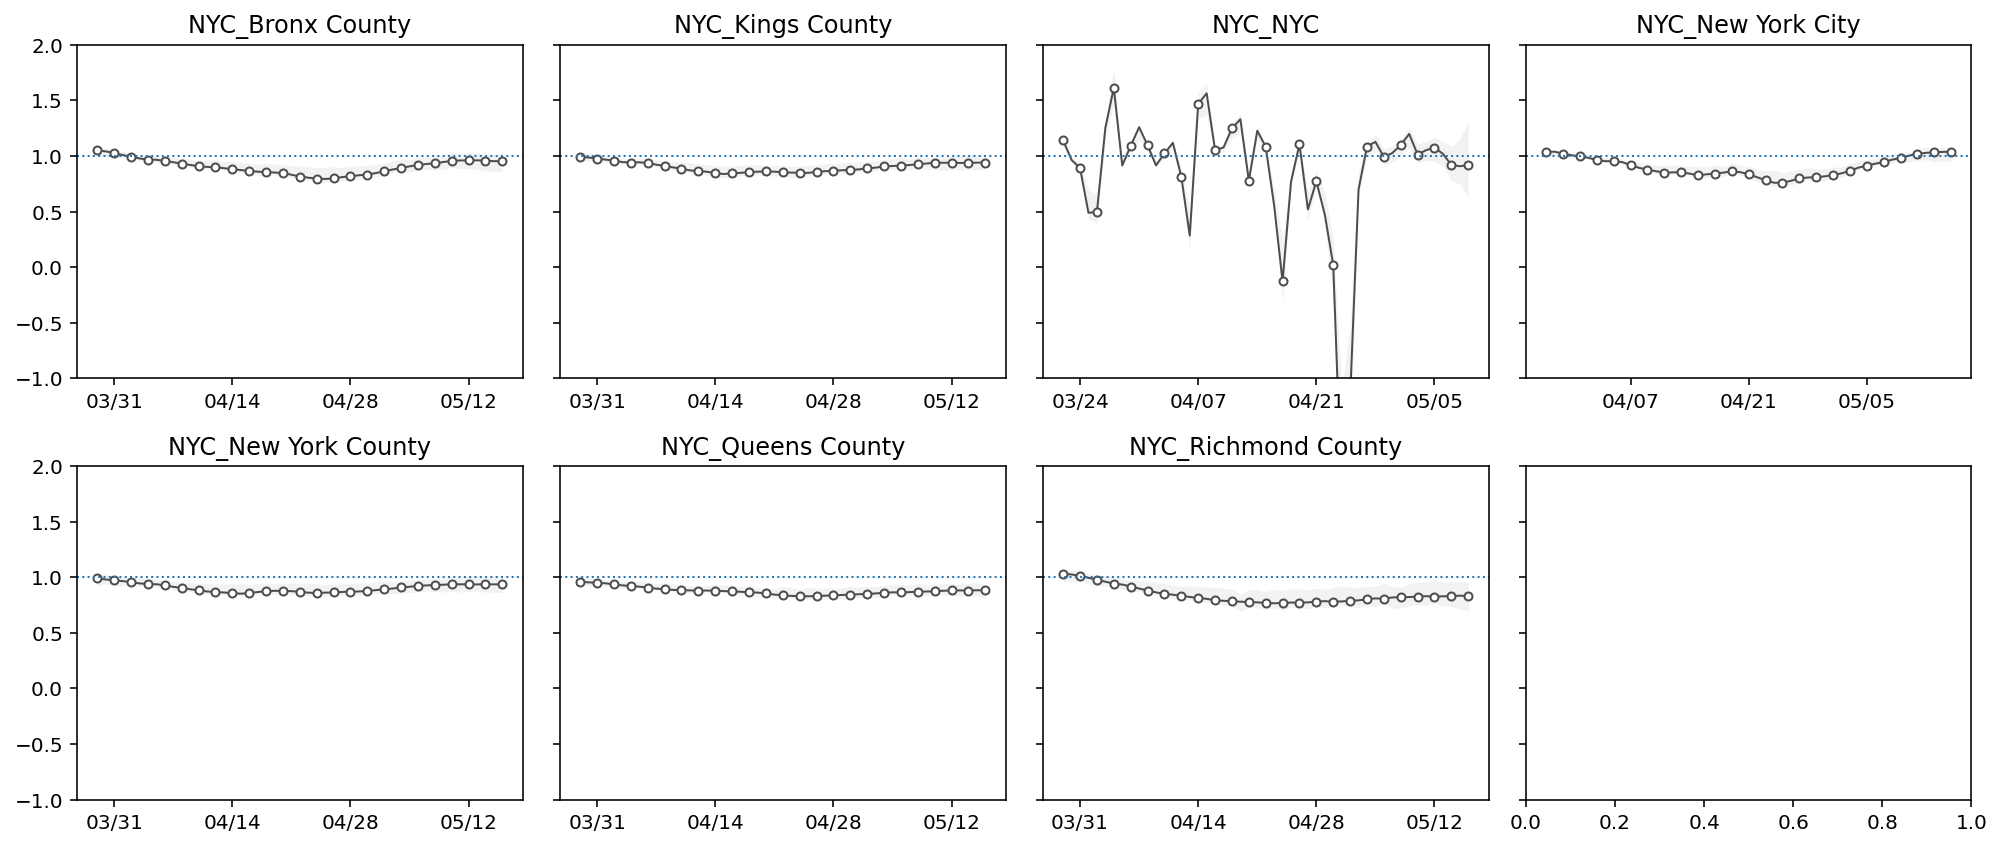

In [0]:
ncols = 4
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, nrows*3),
    sharey='row')

for ax, (state, result) in zip(axes.flat, results.groupby('region')):
    plot_rt(state, result.droplevel(0), ax)

fig.tight_layout()
fig.set_facecolor('w')